# Quick alignment of spots

In [1]:
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd
#import torch
print(os.getpid())

965810


In [49]:
# ChromAn related imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn
import ImageAnalysis3 as ia3
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast
from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive
from ChromAn.src.correction_tools.alignment import generate_drift_crops

In [50]:
# data folder
data_folder = r'/lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907'
# scan subfolders
folders, fovs = data_organization.search_fovs_in_folders(data_folder)
# analysis folder
analysis_folder = os.path.join(data_folder, 'Analysis')

- searching in folder: /lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907
-- 17 folders, 325 fovs detected.


In [51]:
color_usage_df = data_organization.Color_Usage(os.path.join(analysis_folder, "Color_Usage.csv"))

- load color_usage from file: /lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907/Analysis/Color_Usage.csv


In [52]:
color_usage_df

,748,637,545,477,405
Hyb,,,,,
H0M1,r2,m53,NaN,beads,DAPI
H1M2,m1,m2,m3,beads,NaN
H2M3,m4,m5,m6,beads,NaN
H3M4,m7,m8,m9,beads,NaN
H4M5,m10,m11,m12,beads,NaN
H5M6,m13,m14,m15,beads,NaN
H6M7,m16,m17,m18,beads,NaN
H7M8,m19,m20,m21,beads,NaN
H8M9,m25,m26,m27,beads,NaN


In [9]:
save_folder = analysis_folder
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")


segmentation_folder = os.path.join(analysis_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(analysis_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

7 fovs detected
Creating segmentation_folder: /lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907/Analysis/Analysis_0706/Segmentation
Creating cand_spot_folder: /lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907/Analysis/Analysis_0706/CandSpots
Creating decoder_folder: /lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907/Analysis/Analysis_0706/Decoder


In [140]:
_save_filename = save_filenames[0]
with h5py.File(_save_filename, 'r') as _f:
    _all_spots = _f['merfish']['spots'][:]
    _spots_list = [_s[_s[:,0] > 0] for _s in _f['merfish']['spots'][:]]
    _ids = _f['merfish']['ids'][:]
    #_ims = _f['merfish']['ims'][:]
    _drifts = _f['merfish']['drifts'][:]
    _dapi_im = _f.attrs['dapi_im']
    print(_f.attrs.keys())
    

<KeysViewHDF5 ['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel', 'dapi_channel_index', 'dapi_im', 'data_folder', 'debug', 'drift', 'drift_channel', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'merfish_ref_im', 'num_threads', 'parallel', 'ref_filename', 'ref_id', 'rna_ref_im', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi', 'verbose']>


<IPython.core.display.Javascript object>


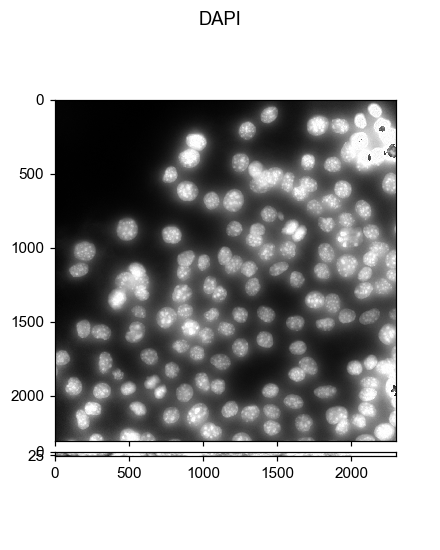

In [142]:
interactive.imshow_mark_3d([_dapi_im], image_names=['DAPI'])

<IPython.core.display.Javascript object>


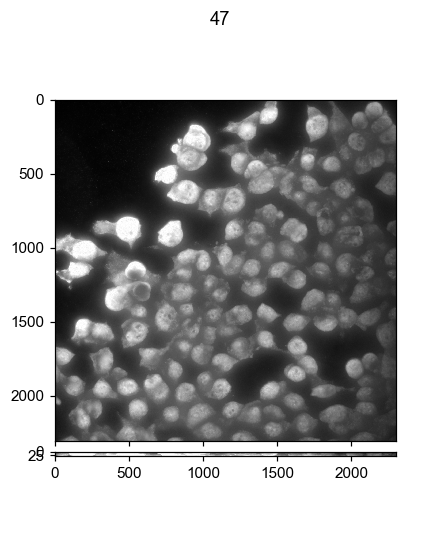

In [139]:
interactive.imshow_mark_3d(_ims, image_names=_ids)

<IPython.core.display.Javascript object>


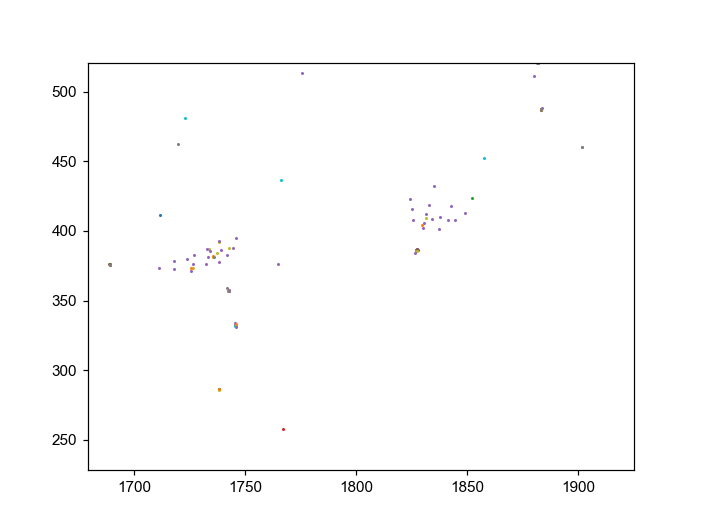

In [41]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
for _spots in _spots_list:
    plt.scatter(_spots[:,3],_spots[:,2], s= 1)

In [30]:
_all_spots[0]

array([[ 2.0231346e+04,  1.3039053e+01,  1.1698337e+03, ...,
         2.5535676e-01, -2.7022296e-01,  1.0121674e+03],
       [ 1.6846656e+04,  1.2551322e+01,  1.1694601e+03, ...,
         1.7846239e-01,  2.4952340e-01,  9.6654144e+02],
       [ 1.9824270e+04,  8.2849436e+00,  1.1649875e+03, ...,
         5.7001691e-02, -1.8262871e-01,  1.3240974e+03],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [31]:
generate_drift_crops()

[array([[ 2.02313457e+04,  1.30390530e+01,  1.16983374e+03, ...,
          2.55356759e-01, -2.70222962e-01,  1.01216742e+03],
        [ 1.68466562e+04,  1.25513220e+01,  1.16946008e+03, ...,
          1.78462386e-01,  2.49523401e-01,  9.66541443e+02],
        [ 1.98242695e+04,  8.28494358e+00,  1.16498755e+03, ...,
          5.70016913e-02, -1.82628706e-01,  1.32409741e+03],
        ...,
        [ 1.44731140e+03,  2.20073242e+01,  2.08626514e+03, ...,
          5.38426101e-01, -3.94879878e-02,  1.06337646e+02],
        [ 9.89878052e+02,  7.83673096e+00,  9.36020386e+02, ...,
          2.59814739e-01, -4.63777214e-01,  1.39779877e+02],
        [ 1.19579236e+03,  1.10303020e+01,  4.23311035e+02, ...,
         -2.04160243e-01, -1.01469725e-01,  1.22851700e+02]], dtype=float32),
 array([[ 2.6861883e+04,  8.1694460e+00,  1.1648641e+03, ...,
          9.5137492e-02, -1.5500943e-01,  1.9704899e+03],
        [ 2.3472729e+04,  1.2133231e+01,  1.1697732e+03, ...,
          1.5527426e-01,  1.5881

In [58]:
intbc_ids = _ids[_ids <= 21]
edit_ids = _ids[(_ids > 21) & (_ids < 52)]

In [130]:
sel_center = _spots_list[list(_ids).index(53)][16,1:4]


In [131]:
sel_local_im = crop_neighboring_area(_ims[list(_ids).index(53)], sel_center, 15)

In [132]:
sel_center

array([  16., 1991.,  913.], dtype=float32)

In [133]:
# crop intbc images:
from ChromAn.src.file_io.image_crop import crop_neighboring_area
intbc_ims = []
for _id in intbc_ids:
    _idx = list(_ids).index(_id)
    # new center
    _im, _dft = _ims[_idx], _drifts[_idx]
    _local_im = crop_neighboring_area(_im, sel_center-_dft, 15)
    intbc_ims.append(_local_im)
    #break

<IPython.core.display.Javascript object>


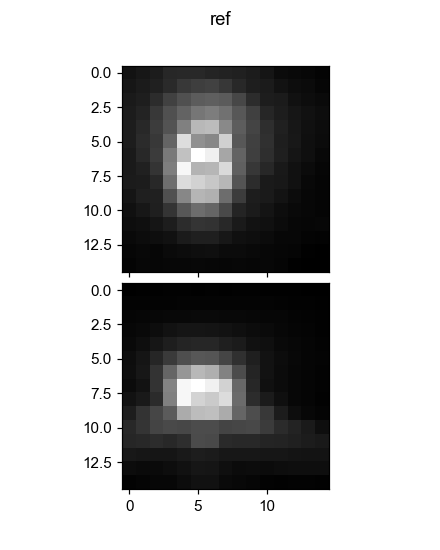

In [134]:
interactive.imshow_mark_3d([sel_local_im] + intbc_ims, image_names=['ref'] + list(intbc_ids))

<IPython.core.display.Javascript object>


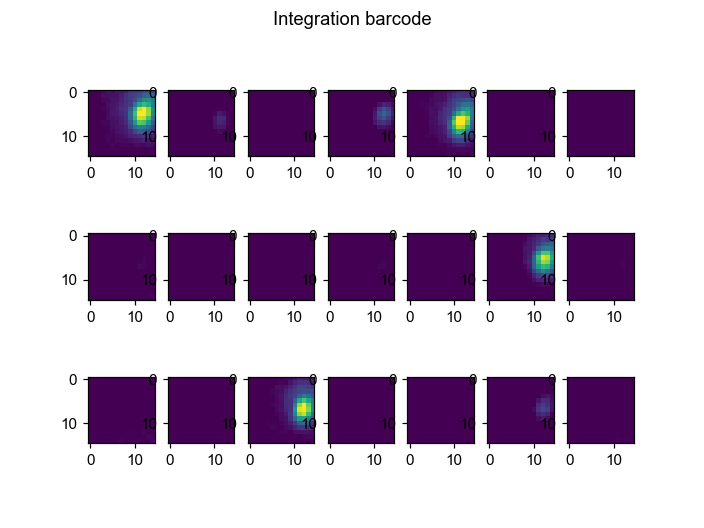

Text(0.5, 0.98, 'Integration barcode')

In [135]:
fig, axes = plt.subplots(3,7)
for _iax, ax in enumerate(np.ravel(axes)):
    ax.imshow(intbc_ims[_iax].max(0), vmin=4000, vmax=20000)
fig.suptitle('Integration barcode')

<IPython.core.display.Javascript object>


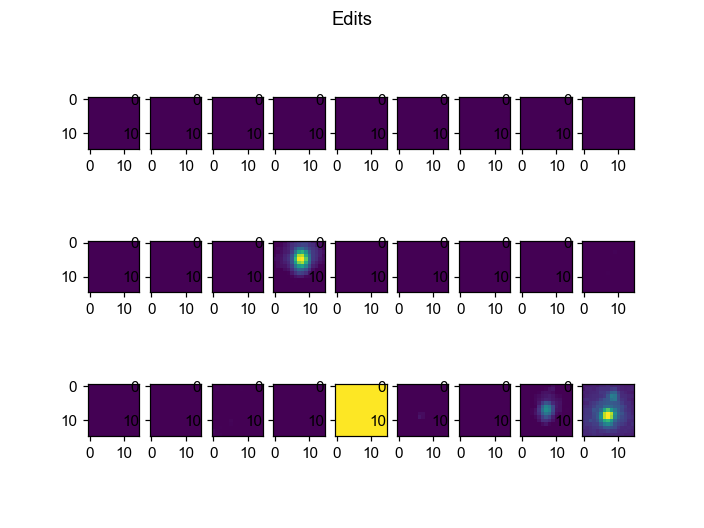

Text(0.5, 0.98, 'Edits')

In [136]:
fig, axes = plt.subplots(3,9)
for _iax, ax in enumerate(np.ravel(axes)):
    ax.imshow(edit_ims[_iax].max(0) , vmin=4000, vmax=20000)
fig.suptitle('Edits')

In [98]:
# crop edit images:
from ChromAn.src.file_io.image_crop import crop_neighboring_area
edit_ims = []
for _id in edit_ids:
    _idx = list(_ids).index(_id)
    # new center
    _im, _dft = _ims[_idx], _drifts[_idx]
    _local_im = crop_neighboring_area(_im, sel_center-_dft, 15)
    edit_ims.append(_local_im)
    #break

<IPython.core.display.Javascript object>


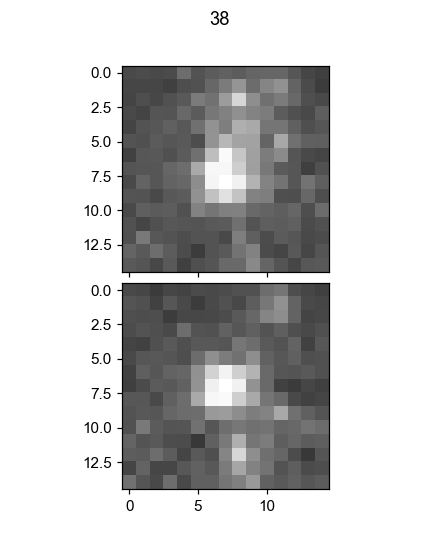

In [99]:
interactive.imshow_mark_3d([sel_local_im] + edit_ims, image_names=['ref'] + list(edit_ids))

In [54]:
np.sum(_ids <= 21)

21